In [30]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report


In [18]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14813123858199388780
]
Num GPUs Available:  0


In [19]:
df = pd.read_json('C:/Users/Rasmu/Documents/Datasets/7_dataset_w_tags.json')
df = df[:500000]
df['Dep'] = df['Dep'].str.upper()
df.head()

,Sentence #,Word,Lemma,Tag,POS,Dep,Polarity,Gender
0,1,organizations,organization,NNS,NOUN,NSUBJ,-0.193345,W
1,1,decided,decide,VBN,VERB,ROOT,-0.034137,W
2,1,drop,drop,VB,VERB,XCOMP,-0.066243,W
3,1,women,woman,NNS,NOUN,NSUBJ,0.353161,W
4,1,accused,accuse,VBD,VERB,ADVCL,-0.015817,W


<AxesSubplot:>

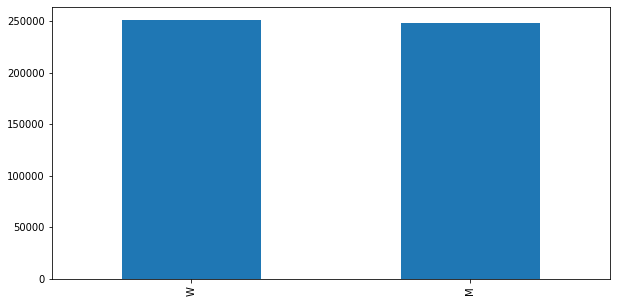

In [20]:
df["Gender"].value_counts().plot(kind="bar", figsize=(10,5))

In [34]:
word_vocab = np.unique(df['Word']).tolist()
sentiment_vocab = np.unique(df['Gender']).tolist()

i_to_word = {i:word for  i, word in enumerate(word_vocab)}
word_to_i = {word:i for  i, word in enumerate(word_vocab)}

i_to_sentiment = {i:sent for  i, sent in enumerate(sentiment_vocab)}
sentiment_to_i = {sent:i for  i, sent in enumerate(sentiment_vocab)}

df['Word_index'] = df['Word'].map(word_to_i)
df['Gender_index'] = df['Gender'].map(sentiment_to_i)

df_grouped = df.groupby(['Sentence #'],as_index=False)['Word', 'Word_index', 'Lemma', 'POS', 'Dep', 'Polarity', 'Gender', 'Gender_index'].agg(lambda x: list(x))
df_grouped = df_grouped.sample(frac=1).reset_index(drop=True)

df_grouped.head(10)

C:\Users\Rasmu\AppData\Local\Temp/ipykernel_24360/3461208999.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(['Sentence #'],as_index=False)['Word', 'Word_index', 'Lemma', 'POS', 'Dep', 'Polarity', 'Gender', 'Gender_index'].agg(lambda x: list(x))


,Sentence #,Word,Word_index,Lemma,POS,Dep,Polarity,Gender,Gender_index
0,11413,"[athletes, competing, Pyeongchang, banner, Oly...","[11864, 14681, 7712, 12240, 6881, 1108, 32011,...","[athlete, compete, Pyeongchang, banner, Olympi...","[NOUN, VERB, PROPN, NOUN, PROPN, PROPN, NOUN, ...","[POBJ, ACL, POBJ, POBJ, COMPOUND, POBJ, POBJ, ...","[-0.214967042461347, -0.07352551708063401, -0....","[M, M, M, M, M, M, M, M, M, M, M, M, M, M, M, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,15413,"[need, tell, cost, abuse, got, read, journals,...","[24582, 32073, 15348, 10661, 19987, 27704, 223...","[need, tell, cost, abuse, get, read, journal, ...","[VERB, VERB, NOUN, NOUN, VERB, VERB, NOUN, NOUN]","[ROOT, XCOMP, NSUBJ, POBJ, ADVCL, XCOMP, DOBJ,...","[-0.22107488444376303, -0.078510476534681, -0....","[W, W, W, W, W, W, W, W]","[1, 1, 1, 1, 1, 1, 1, 1]"
2,19610,"[Delivery, services, like, Postal, Service, UP...","[2884, 29615, 22989, 7477, 8584, 9833, 3719]","[delivery, service, like, Postal, Service, UPS...","[NOUN, NOUN, ADP, PROPN, PROPN, PROPN, PROPN]","[COMPOUND, NSUBJ, PREP, COMPOUND, POBJ, CONJ, ...","[-0.04012812441764, -0.244166104186568, -0.068...","[M, M, M, M, M, M, M]","[0, 0, 0, 0, 0, 0, 0]"
3,28621,"[agreed, sue, instead, accepted, figure, settl...","[11102, 31470, 21879, 10691, 18908, 29635, 391...","[agree, sue, instead, accept, figure, settleme...","[VERB, VERB, ADV, VERB, NOUN, NOUN, PROPN, NOU...","[ROOT, XCOMP, ADVMOD, CONJ, COMPOUND, DOBJ, PO...","[-0.05705146961145201, -0.036227309854455006, ...","[W, W, W, W, W, W, W, W, W, W]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
4,56777,"[underwent, successful, surgery, overcome, deg...","[33220, 31451, 31641, 25417, 16148, 18514, 168...","[undergo, successful, surgery, overcome, degen...","[VERB, ADJ, NOUN, VERB, ADJ, NOUN, NOUN, NOUN,...","[RELCL, AMOD, DOBJ, ADVCL, AMOD, COMPOUND, DOB...","[0.0011499720830520001, -0.095754174890445, 0....","[M, M, M, M, M, M, M, M, M, M, M, M, M, M, M, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,66967,"[course, boom, unemployment, went]","[15422, 12941, 33262, 34333]","[course, boom, unemployment, go]","[ADV, NOUN, NOUN, VERB]","[ADVMOD, POBJ, NSUBJ, ROOT]","[-0.045929943089273007, -0.025938487759388004,...","[M, M, M, M]","[0, 0, 0, 0]"
6,48534,"[Professor, Law, Cornell, Law, School]","[7598, 5574, 2522, 5574, 8470]","[Professor, Law, Cornell, Law, School]","[PROPN, PROPN, PROPN, PROPN, PROPN]","[ATTR, POBJ, COMPOUND, COMPOUND, POBJ]","[-0.013168331303858001, -0.02199282054907, -0....","[W, W, W, W, W]","[1, 1, 1, 1, 1]"
7,14823,"[knew, abused, said, gymnast, victim, impact, ...","[22543, 10662, 29078, 20290, 33900, 21277, 30966]","[know, abuse, say, gymnast, victim, impact, st...","[VERB, VERB, VERB, NOUN, NOUN, NOUN, NOUN]","[CCOMP, CCOMP, ROOT, COMPOUND, COMPOUND, COMPO...","[-0.09947018530304601, 0.002200180485177, -0.5...","[W, W, W, W, W, W, W]","[1, 1, 1, 1, 1, 1, 1]"
8,24735,"[risk, cost, guarantee, higher, bravery, needed]","[28820, 15348, 20216, 20721, 13091, 24583]","[risk, cost, guarantee, high, bravery, need]","[NOUN, NOUN, VERB, ADJ, NOUN, VERB]","[NSUBJ, CONJ, ROOT, ACOMP, NSUBJPASS, CONJ]","[-0.16096815605404302, -0.271767367859921, -0....","[W, W, W, W, W, W]","[1, 1, 1, 1, 1, 1]"
9,62389,"[scandal, broke, bank, ended, sales, targets, ...","[29208, 13209, 12224, 17803, 29095, 31948, 138...","[scandal, break, bank, end, sale, target, chan...","[NOUN, VERB, NOUN, VERB, NOUN, NOUN, VERB, NOU...","[NSUBJ, ADVCL, NSUBJ, ROOT, COMPOUND, DOBJ, CO...","[-0.038467613154390005, -0.07948425231613, -0....","[M, M, M, M, M, M, M, M, M, M, M, M, M, M, M, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [22]:
max_word = len(word_vocab)
max_sent = len(sentiment_vocab)

words = df_grouped['Word_index'].tolist()
sentiments = df_grouped['Gender_index'].tolist()


max_length = max([len(w) for w in words])

pad_words = pad_sequences(words, maxlen=max_length, dtype='int32', padding='post', value= max_word - 1)

pad_sentiment = pad_sequences(sentiments, maxlen=max_length, dtype='int32', padding='post', value= 1)
n_sentiments = len(sentiment_to_i)

pad_sentiment = [to_categorical(i, num_classes=n_sentiments) for i in pad_sentiment]

train_words, test_words, train_sentiments, test_sentiments = train_test_split(pad_words, pad_sentiment, test_size=0.4, random_state=42, shuffle=True)


[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[32247 23650 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899
 34899 34899 34899 34899 34899 34899 34899 34899 3489

In [23]:
input_dim = len(word_vocab)+1
output_dim = 64
input_length = max([len(s) for s in df_grouped['Word_index'].tolist()])

In [24]:
model = tf.keras.models.Sequential(
    [
        layers.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length), # Embedding vs Input layer
        layers.Bidirectional(layers.LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'),
        layers.LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5),
        layers.TimeDistributed(layers.Dense(n_sentiments, activation="softmax")) #Use softmax for activation HOML page 383
    ]
)

adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

#Hyper params to change - learning rate, number of layers and neurons, activations functions

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 
model.summary()
plot_model(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 97, 64)            2233664   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 97, 128)           66048     
_________________________________________________________________
lstm_3 (LSTM)                (None, 97, 64)            49408     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 97, 2)             130       
Total params: 2,349,250
Trainable params: 2,349,250
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [25]:
root_logdir = os.path.join(os.curdir, "sa_logs")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
run_log_dir

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

In [26]:
print(train_words.shape)
print(np.array(train_sentiments).shape)

history = model.fit(train_words, np.array(train_sentiments), epochs=10, callbacks=[tensorboard_cb])
#model.save("bidir_lstm.h5")

(35426, 97)
(35426, 97, 2)
Epoch 1/10
1108/1108 [==============================] - 176s 154ms/step - loss: 0.0553 - accuracy: 0.9752
Epoch 2/10
1108/1108 [==============================] - 169s 153ms/step - loss: 0.0272 - accuracy: 0.9886
Epoch 3/10
1108/1108 [==============================] - 136s 123ms/step - loss: 0.0188 - accuracy: 0.9923
Epoch 4/10
1108/1108 [==============================] - 133s 120ms/step - loss: 0.0144 - accuracy: 0.9942
Epoch 5/10
1108/1108 [==============================] - 133s 120ms/step - loss: 0.0117 - accuracy: 0.9953
Epoch 6/10
1108/1108 [==============================] - 846s 764ms/step - loss: 0.0097 - accuracy: 0.9961
Epoch 7/10
1108/1108 [==============================] - 124s 111ms/step - loss: 0.0082 - accuracy: 0.9966
Epoch 8/10
1108/1108 [==============================] - 128s 116ms/step - loss: 0.0071 - accuracy: 0.9970
Epoch 9/10
1108/1108 [==============================] - 131s 118ms/step - loss: 0.0063 - accuracy: 0.9973
Epoch 10/10
1108/11

In [27]:
y_pred = model.predict(test_words) #Calculates probability for each tag

print(test_words[1])
print(np.array(test_sentiments)[1])

[11361 23516 32102 17501  9797  3722  8068 24671 22758 34899 34899 34899
 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899
 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899
 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899
 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899
 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899
 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899
 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899 34899
 34899]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0

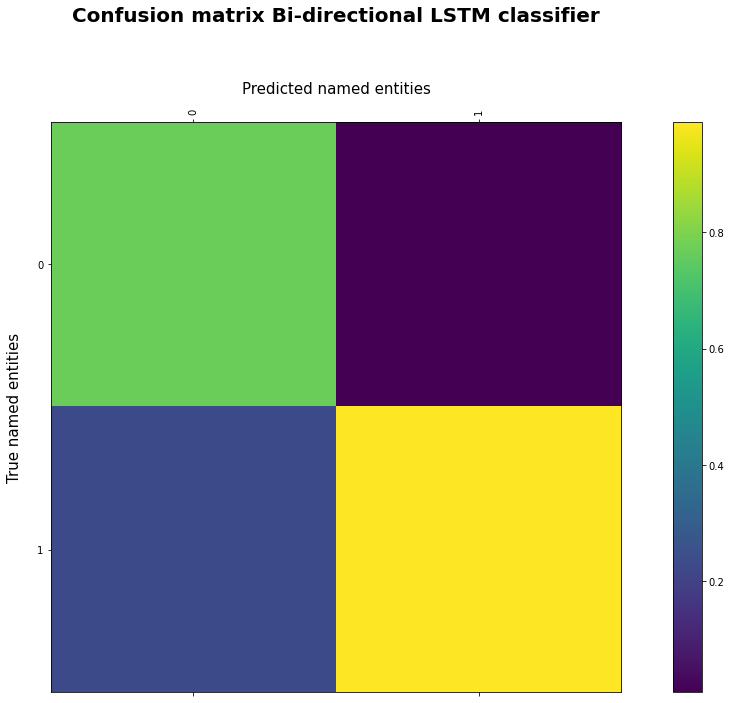

In [28]:
y_classes = y_pred.argmax(axis=-1)

cm_true = y_classes.flatten()
cm_pred = np.array(test_sentiments).argmax(axis=-1).flatten()

cm = confusion_matrix(cm_pred, cm_true, normalize='pred')
fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted named entities', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True named entities', fontsize = 15, labelpad=15.0)
ax.set_title('Confusion matrix Bi-directional LSTM classifier',fontweight="bold", size=20, pad=100.0)

fig.colorbar(cax)
plt.xticks(range(2), [0,1], rotation=90)
plt.yticks(range(2), [0,1])
plt.show()

In [32]:
report = classification_report(cm_true, cm_pred, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:2]
df_perf_2.insert(loc=0, column='Gender', value=sentiment_vocab)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2

C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Rasmu\AppData\Local\Temp/ipykernel_24360/1661216837.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)


,Gender,precision,recall,f1-score,support
0,M,0.79,0.77,0.78,101327.0
1,W,0.99,0.99,0.99,2189619.0
